<a href="https://colab.research.google.com/github/Matammanjunath/Matammanjunath/blob/main/20220328_SMAinv_clipping_data_analysis_Manju.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# plt.rcParams.update({'font.size': 18,'font.family' : 'Times New Roman','font.weight':'normal'})  # This set font size, family of all plots
import seaborn as sns
!cp /content/drive/MyDrive/2022_04_13_ClippingExperiment_ResultsAnalysis/plot_templates_manju.py .
import plot_templates_manju
from datetime import timedelta


<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Data left after the POA filter is 99%


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


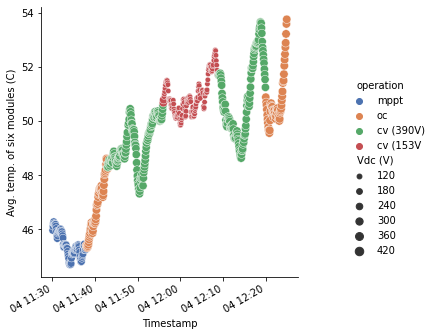

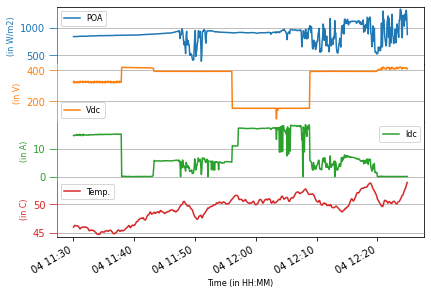

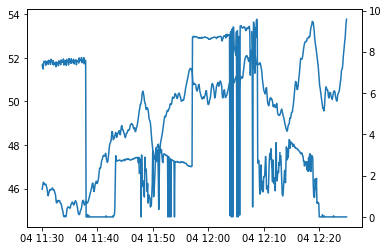

In [ ]:
if __name__ == "__main__":
    
    ####### Jinko module data from spec sheet
    voc_stc = 38.8
    pmpp_stc = 270
    isc_stc = 9.09
    beta = (-0.3/100)*voc_stc ### Voc temperature coefficient of Voc
    alpha = (0.06/100)*isc_stc ### Isc temperature coefficient of Isc
    gama = (-0.40/100)*pmpp_stc ### Pmpp temperature coefficient 
    gref = 1000 ### Reference Irradiance
    tref = 25 ### Reference temperature
    pvclas,project = str('Outdoor'),str('8157_UCF') # 1min = A class
    # experiment day
    day = '2022-04-04'
    daylbl = '2022_04_04'
    #### Import files 
    fold_loc = '/content/drive/MyDrive/2022_04_13_ClippingExperiment_ResultsAnalysis/'
    # Relevant file name
    file_name = '8157_MySql_Pordis_Accu_ModTempData_%s_Manju'%(daylbl)
    df = pd.read_csv(fold_loc+'%s.csv'%(file_name))
    ## Demelt the dataframe
    df = df.pivot(index='measdatetime', columns='modbus_readout_id')['final_value']
    col_ids = df.columns.tolist()
    ## Import modbus readout ids and labels
    mid = pd.read_csv(fold_loc+'8157_MySql_ModbusReadoutIDs_Manju.csv')
    req_labls = mid[mid['modbus_readout_id'].isin(col_ids)]
    ## Replace dataframe modbus ids with labels
    df.rename(columns=dict(zip(req_labls['modbus_readout_id'],req_labls['channel_name'])),inplace=True)
    ## Import clipping experiment timestamp details
    cet = pd.read_excel(fold_loc+'8157_clippingexp_timestamp.xlsx')
    cet.set_index('timestamp',inplace=True,drop=True)
    cet.index = pd.to_datetime(cet.index,format='%Y-%m-%d %H:%M:%S')
    cet = cet.loc[day]
    #
    # Set index
    df.index = pd.to_datetime(df.index,format='%Y-%m-%d %H:%M:%S')
    print(type(df.index))
    # The OSIPI dataset saved on daylight saving time; bring it to est
    df.index = df.index+timedelta(hours=1)
    ## drop unwanted data in the main df
    df = df[(df.index>cet.index[0])&(df.index<cet.index[-1])]
    ##
    # Rename columns
    df.rename(inplace=True, columns={"Irradiance":"POA (W/m2)",
                                        "R02.C06_Temp":"TM1",
                                        "R02.C01_Temp":"TM6",
                                        "R01.C04_Temp":"TM10",
                                        "R02.C10_Temp":"TM15",
                                        "R01.C13_Temp":"TM20",
                                        "R01.C08_Temp":"TM23",
                                        "S_1_VOLTAGE":"S1Vdc (V)",
                                        "S_1_CURRENT":"S1Idc (A)",
                                        "S_2_VOLTAGE":"S2Vdc (V)",
                                        "S_2_CURRENT":"S2Idc (A)"})
    ### Combine df and cet dataframes
    # print(cet.index)
    # print(df.index)
    df = pd.concat([df,cet],axis=1)
    df['operation'] = df['operation'].fillna(method='ffill')
    ## Filter-1: Drop low POA data
    tn = len(df)
    df = df[df['POA (W/m2)']>20]
    print("Data left after the POA filter is %d%%"%(len(df)*100/tn))
    
    ### DC voltage, current
    df['Idc (A)'] = df[['S1Idc (A)','S2Idc (A)']].sum(axis=1)
    df['Vdc (V)'] = df['S1Vdc (V)']
    df['Pdc (W)'] = df['Vdc (V)']*df['Idc (A)']
    df['S1T'] = df[['TM1','TM6','TM10',]].mean(axis=1)
    df['S2T'] = df[['TM15','TM20','TM23',]].mean(axis=1)
    df['Avg. temp. of six modules (C)'] = df[['S1T','S2T']].mean(axis=1)
    ## Rate of change of temperature
    df['DelT'] = df['Avg. temp. of six modules (C)'].diff(1)
    ## operating condition
    # df['Operation'] = np.where(((df['Pdc (W)']>1100)&(df['Pdc (W)']<1170)& (df.index> '2022-03-25') & (df.index< '2022-03-26')),
    #                            'Clipping (6.2)','MPP (1)')
    ## Time difference between the samples
    from datetime import datetime
    df['Timestamp'] = df.index
    df['DelTime'] = df['Timestamp'].diff(1)
    parms = ['Pdc (W)','Vdc (V)','Avg. temp. of six modules (C)']
    ### normalize the df and produce a nf dataframe
    # nf = df
    # nf[['Pdc (W)','Vdc (V)','Avg. temp. of six modules (C)']] = nf[['Pdc (W)','Vdc (V)','Avg. temp. of six modules (C)']].apply(lambda x: x/x.max(),axis=0)
    # # melt df and create new df
    # ndf = nf.reset_index().melt(id_vars =['DelT','POA (W/m2)','operation','Timestamp'],
    #                                                       value_vars=parms,
    #                                                       value_name='Magnitude',
    #                                                       var_name='Parameter')
    ### 
    xlbl = 'Timestamp'#'POA (W/m2)'#'DelTime'#
    ylbl = 'Avg. temp. of six modules (C)'#'Magnitude'
    hlbl = 'operation'
    slbl = 'Vdc (V)'#'POA (W/m2)'
    sns.relplot(x=xlbl,#'Pdc (W)',#'measdatetime',#
                y=ylbl,#'DelT',#
                data=df,
                hue = hlbl,#row='Parameter',
                palette='deep',kind='scatter',
                size =slbl)
    # plt.ylim([-0.5,0.5])
    temp_name = fold_loc+ 'tempplot.png'
    plt.subplots_adjust(left=0.12, right=0.70, top=0.95, bottom=0.10)
    plt.gcf().autofmt_xdate()
    plt.savefig(temp_name, dpi=500)
    plt.show()
    # Time vs Pdc, Vdc
    plot_templates_manju.oscilloscope_plot(df,x='Timestamp',
                                           y=['POA (W/m2)','Vdc (V)','Idc (A)','Avg. temp. of six modules (C)'],
                                           xlbl=['Time','HH:MM'],
                                           ylbl=[['POA','W/m2'],['Vdc','V'],
                                                 ['Idc','A'],['Temp.','C']],
                                           saveformat=fold_loc+ 'oscilloscope_plot.png')

    ####
    fig,ax1 = plt.subplots()
    ax1.plot(df.index,df['Avg. temp. of six modules (C)'])
    ax2 = ax1.twinx()
    ax2.plot(df.index,df['S2Idc (A)'])
    plt.show()
    # # # 3d interactive plot appearing in browser html window
    # vlbl,wlbl = 'Pdc (W)','Vdc (V)' #'measdatetime'
    # xlbl,ylbl,zlbl = 'POA (W/m2)','PVtemp','Pdc (W)'#'Day time (hh)'#
    # dataframe_html_3dscatterplot(df.dropna(subset=[vlbl]).loc[day].reset_index(),
    #                           xlbl,ylbl,zlbl,
    #                           clr_col = wlbl,
    #                           size_col=vlbl)
    # print(nf['Timestamp'])